In [1]:
import pandas as pd
from model import preprocess_data_lgbm as preprocess_data
import lightgbm as lgb

from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd

In [2]:
gbdt_db0_model = "/home/user14/Cyber/MroPred/output/lgbm/benchmark/lgbm_tuning_results_gbdt_db0_mp1_pt1_as_weekly_tw8/lgbm_tuning_experiment/train_lgbm_fe064_00001_1_learning_rate=0.0358,max_depth=19,num_leaves=368_2025-06-09_02-32-54/checkpoint_000000/model.txt"

gbdt_db1_model = "/home/user14/Cyber/MroPred/output/lgbm/our_model/lgbm_tuning_results_gbdt_db1_mp1_pt1_as_weekly_tw8/lgbm_tuning_experiment/train_lgbm_89478_00002_2_learning_rate=0.0099,max_depth=8,num_leaves=959_2025-06-09_10-22-05/checkpoint_000000/model.txt"

rf_db0_model = "/home/user14/Cyber/MroPred/output/lgbm/benchmark/lgbm_tuning_results_rf_db0_mp1_pt1_as_weekly_tw8/lgbm_tuning_experiment/train_lgbm_1a76b_00000_0_bagging_fraction=0.7738,bagging_freq=7,feature_fraction=0.7924,max_depth=18,num_leaves=425_2025-06-09_09-50-21/checkpoint_000000/model.txt"

rf_db1_model = "/home/user14/Cyber/MroPred/output/lgbm/our_model/lgbm_tuning_results_rf_db1_mp1_pt1_as_weekly_tw8/lgbm_tuning_experiment/train_lgbm_88c5d_00000_0_bagging_fraction=0.6658,bagging_freq=4,feature_fraction=0.7009,max_depth=15,num_leaves=577_2025-06-09_02-01-00/checkpoint_000000/model.txt"

dart_db0_model = "/home/user14/Cyber/MroPred/output/lgbm/benchmark/lgbm_tuning_results_dart_db0_mp1_pt1_as_weekly_tw8/lgbm_tuning_experiment/train_lgbm_c0510_00007_7_learning_rate=0.0211,max_depth=17,num_leaves=314_2025-06-09_10-02-09/checkpoint_000000/model.txt"

dart_db1_model = "/home/user14/Cyber/MroPred/output/lgbm/our_model/lgbm_tuning_results_dart_db1_mp1_pt1_as_weekly_tw8/lgbm_tuning_experiment/train_lgbm_2388e_00014_14_learning_rate=0.0588,max_depth=17,num_leaves=144_2025-06-09_02-19-38/checkpoint_000000/model.txt"

In [3]:
full_mro_data_path = "./Data/our_model/data_lgbm_db1_mp1_pt1_as_weekly_tw8.gzip"
maintenance_mro_data_path = './Data/maintenance_repair_comparison/our_model_data_maintenance.gzip'
repair_mro_data_path = './Data/maintenance_repair_comparison/our_model_data_repair.gzip'


In [4]:
# data_path = full_mro_data_path
# data_path = maintenance_mro_data_path
data_path = repair_mro_data_path
# -------------------------------------------------
# best_model_path = gbdt_db1_model
# best_model_path = rf_db1_model
best_model_path = dart_db1_model


In [5]:
def prepare_data(data: pd.DataFrame):
    """Load and split the dataset into train, validation, and test sets."""

    train_dataset = data[data["group"] == "train"]
    valid_dataset = data[data["group"] == "valid"]
    test_dataset = data[data["group"] == "test"]

    train_dataset = train_dataset.drop(["group", "id"], axis=1)
    valid_dataset = valid_dataset.drop(["group", "id"], axis=1)
    test_dataset = test_dataset.drop(["group", "id"], axis=1)

    return train_dataset, valid_dataset, test_dataset


data_lgbm = pd.read_parquet(data_path)
train_dataset, valid_dataset, test_dataset = prepare_data(data_lgbm)

In [6]:
model = lgb.Booster(model_file=best_model_path)

In [7]:
X_test = test_dataset.drop(columns=["target_mro"], axis=1)
y_test = test_dataset["target_mro"]

In [8]:
X_test.columns.to_list()

['est_hh_incm_prmr_cd',
 'purchaser_age_at_tm_of_purch',
 'input_indiv_gndr_prmr_cd',
 'gmqualty_model',
 'umf_xref_finc_gbl_trim',
 'engn_size',
 'purchase_time',
 'tavg_mean_1',
 'tavg_sum_1',
 'tavg_max_1',
 'tavg_min_1',
 'tavg_std_1',
 'tavg_skew_1',
 'random_avg_traffic_mean_1',
 'random_avg_traffic_sum_1',
 'random_avg_traffic_max_1',
 'random_avg_traffic_min_1',
 'random_avg_traffic_std_1',
 'random_avg_traffic_skew_1',
 'hard_braking_mean_1',
 'hard_braking_sum_1',
 'hard_braking_max_1',
 'hard_braking_min_1',
 'hard_braking_std_1',
 'hard_braking_skew_1',
 'hard_acceleration_mean_1',
 'hard_acceleration_sum_1',
 'hard_acceleration_max_1',
 'hard_acceleration_min_1',
 'hard_acceleration_std_1',
 'hard_acceleration_skew_1',
 'speeding_sum_mean_1',
 'speeding_sum_sum_1',
 'speeding_sum_max_1',
 'speeding_sum_min_1',
 'speeding_sum_std_1',
 'speeding_sum_skew_1',
 'day_mileage_mean_1',
 'day_mileage_sum_1',
 'day_mileage_max_1',
 'day_mileage_min_1',
 'day_mileage_std_1',
 'day_m

In [9]:
importances_gain = model.feature_importance(importance_type='gain')
feature_names = model.feature_name()

df_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances_gain
})

In [10]:
def extract_category(feature_name):
    if feature_name.startswith("speeding_"):
        return "Speeding"
    elif feature_name.startswith("day_mileage_"):
        return "Daily Mileage"
    elif feature_name.startswith("tavg_"):
        return "Average Temperature"
    elif feature_name.startswith("random_avg_traffic_"):
        return "Random Average Traffic"
    elif feature_name.startswith("hard_braking_"):
        return "Hard Braking"
    elif feature_name.startswith("hard_acceleration_"):
        return "Hard Acceleration"
    elif feature_name == "input_indiv_gndr_prmr_cd":
        return "Gender"
    elif feature_name == "gmqualty_model":
        return "Car Model"
    elif feature_name == "umf_xref_finc_gbl_trim":
        return "UMF Xref Financial Global Trim"
    elif feature_name == "purchase_time":
        return "Purchase Time"
    elif feature_name == "est_hh_incm_prmr_cd":
        return "Estimated Household Income"
    elif feature_name == "purchaser_age_at_tm_of_purch":
        return "Purchaser Age"
    elif feature_name == "engn_size":
        return "Engine Size"
    elif feature_name == "mro_prev":
        return "Previous MRO"
    else:
        return None


df_imp["Category"] = df_imp["Feature"].apply(extract_category)

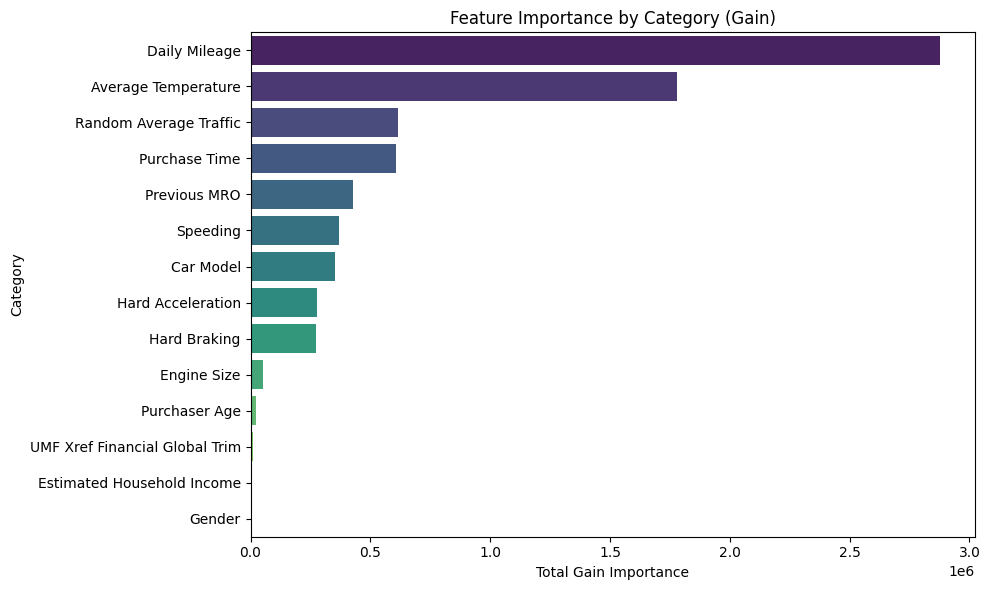

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df_grouped = df_imp.groupby("Category")["Importance"].sum().sort_values(ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(
    x=df_grouped.values,
    y=df_grouped.index,
    palette="viridis",
    hue=df_grouped.index,
    legend=False,
)
plt.title("Feature Importance by Category (Gain)")
plt.xlabel("Total Gain Importance")
plt.ylabel("Category")
plt.tight_layout()
plt.show()